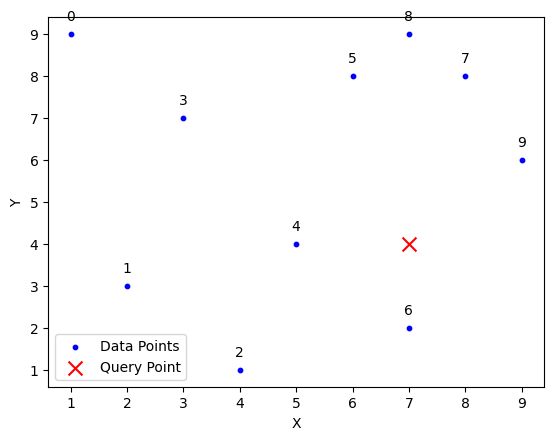

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data=np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([7, 4])

def plot_dataset(data,query_pt):
    plt.scatter(data[:, 0], data[:, 1], color='blue', s=10, label='Data Points')
    plt.scatter(query_pt[0], query_pt[1], color='red', marker='x', s=100, label='Query Point')
    for i, txt in enumerate(range(10)):
        plt.annotate(txt, (data[i][0], data[i][1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

plot_dataset(data,query_pt)
plt.show()

Naive K-Nearest Neighbours

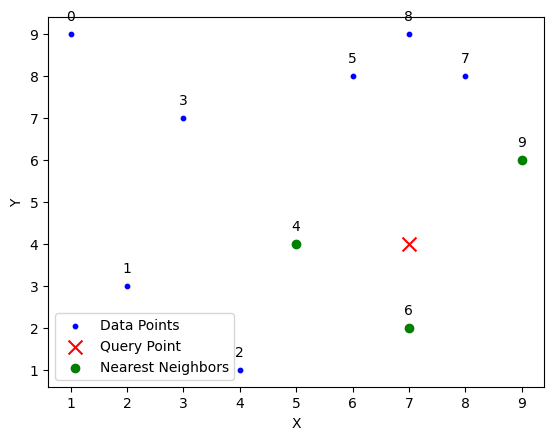

In [2]:
def naive_knn(data, query, k):
    distances = [np.linalg.norm(query-point) for point in data]
    indices = np.argsort(distances)[:k]
    sorted_distances=np.sort(distances)[:k]
    return sorted_distances,indices

distances, indices = naive_knn(data,query_pt,3)
nearest_neighbor_pts = data[indices] 
plot_dataset(data,query_pt)
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='green', label='Nearest Neighbors')
plt.legend()
plt.show()

KD Trees for KNN

In [3]:
class KDNode:
    def __init__(self,split,leaf_points=None, left=None, right=None):
        self.leaf_points=leaf_points
        self.split = split  
        self.left = left
        self.right = right

def build_kdtree(points,min_points, depth=0):
    if len(points) <=min_points:
        return KDNode(split=None, leaf_points=points)

    dim=data.shape[1]
    axis = depth % dim
    points = sorted(points, key=lambda x: x[axis])
    median = len(points) // 2
    
    return KDNode(
        points[median],
        leaf_points=None,
        left=build_kdtree(points[:median],min_points, depth + 1),
        right=build_kdtree(points[median + 1:],min_points, depth + 1)
    )

def distance(point1,point2):
    return np.linalg.norm(point1-point2)

def knn_search(node, target, k,data, depth=0):

    dim = len(target)
    while node.left is not None:
        axis = depth % dim
        if target[axis] < node.split[axis]:
            node = node.left
            depth += 1
        else:
            node = node.right
            depth += 1
    
    subset = node.leaf_points
    distances = {tuple(i): distance(target, i) for i in subset}  # Convert array to tuple
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    k_neighbors = sorted_distances[:k]

    return k_neighbors

kdtree = build_kdtree(data,min_points=3)
k_neighbors = knn_search(kdtree, query_pt,3,data)
print("Nearest neighbors:", k_neighbors)


Nearest neighbors: [((7, 2), 2.0), ((9, 6), 2.8284271247461903)]


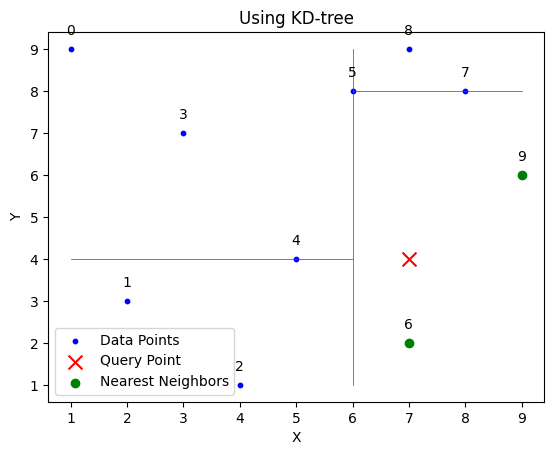

In [4]:
import matplotlib.pyplot as plt

def plot_kdtree(node, xmin, xmax, ymin, ymax, depth=0):
    if node.left is None:
        return
    
    dim = len(node.split)
    axis = depth % dim
    split_value = node.split[axis]
    
    # Plot splitting line
    if axis == 0:
        plt.plot([split_value, split_value], [ymin, ymax], color='green', linestyle='-', linewidth=0.5)
        plot_kdtree(node.left, xmin, split_value, ymin, ymax, depth + 1)
        plot_kdtree(node.right, split_value, xmax, ymin, ymax, depth + 1)
    else:
        plt.plot([xmin, xmax], [split_value, split_value], color='green', linestyle='-', linewidth=0.5)
        plot_kdtree(node.left, xmin, xmax, ymin, split_value, depth + 1)
        plot_kdtree(node.right, xmin, xmax, split_value, ymax, depth + 1)

# Example usage
plot_dataset(data,query_pt)
nearest_neighbor_pts = np.array([neighbor[0] for neighbor in k_neighbors])
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='green', label='Nearest Neighbors')
plot_kdtree(kdtree, np.min(data[:, 0]), np.max(data[:, 0]), np.min(data[:, 1]), np.max(data[:, 1]))
plt.title('Using KD-tree')
# plt.grid(True)
plt.legend()
plt.show()


LSH with KNN 

Approximate Nearest Neighbors: [4, 9, 5]


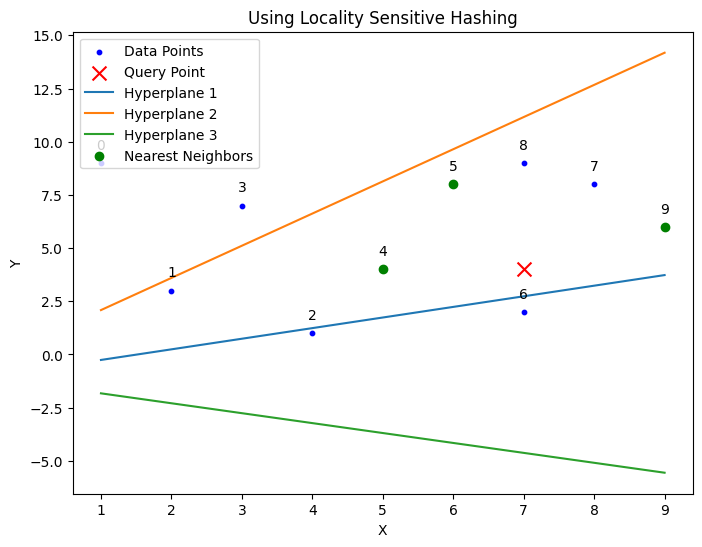

In [5]:
class LSH:
    def __init__(self, num_hyperplanes=10):
        self.num_hyperplanes = num_hyperplanes
        self.projections = None
        self.hash_tables = {i: [] for i in range(2**num_hyperplanes)}

    def fit(self, data):
        np.random.seed(69)
        self.projections = np.random.randn(data.shape[1] + 1, self.num_hyperplanes)
        X_aug = np.hstack([np.ones((data.shape[0], 1)), data])
        bin_codes = (X_aug @ self.projections>0).astype(int)
        for i, hash_code in enumerate(bin_codes):
            bucket_index = int(''.join(map(str, hash_code)), 2)
            self.hash_tables[bucket_index].append(i)

    def query(self, query_point,data, k):
        query_point_aug = np.hstack([[1], query_point])
        hash_code = (query_point_aug @ self.projections>0).astype(int)
        bucket_index = int(''.join(map(str, hash_code)), 2)
        candidate_indices = self.hash_tables[bucket_index]
        distances = [np.linalg.norm(query_point - data[i]) for i in candidate_indices]
        sorted_indices = np.argsort(distances)[:k]
        return [candidate_indices[i] for i in sorted_indices]
    
    def plot_hyperplanes(self,data,query_pt): 
        plot_dataset(data,query_pt)
        for i in range(self.num_hyperplanes):
            x1 = np.array([min(data[:, 0]), max(data[:, 0])])
            x2 = (-self.projections[0, i] - self.projections[1, i]*x1) / self.projections[2, i]
            plt.plot(x1, x2, label=f'Hyperplane {i+1}')    
        plt.title('Using Locality Sensitive Hashing')

lsh = LSH(num_hyperplanes=3)
lsh.fit(data)
k = 3
nearest_neighbors = lsh.query(query_pt,data, k)
print("Approximate Nearest Neighbors:", nearest_neighbors)
nearest_neighbor_pts=data[nearest_neighbors]
plt.figure(figsize=(8, 6))
lsh.plot_hyperplanes(data,query_pt)
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='green', label='Nearest Neighbors')
plt.legend()
plt.show()

In [6]:
import tracemalloc
import time
# Here KD Tree has 50 leaf size and LSH has 10 hyperplanes
def metrics(data_size, num_dimensions, k,algo):
    
    random_data = np.random.rand(data_size, num_dimensions)
    random_query_pt = np.random.rand(1, num_dimensions)
    if(algo=='kdtree'):
        tracemalloc.start()
        start_train_time = time.time()
        kdtree = build_kdtree(random_data,min_points=50)
        end_train_time = time.time()

        start_test_time = time.time()
        k_neighbors = knn_search(kdtree,random_query_pt[0],k,random_data)
        end_test_time = time.time()
        train_time = end_train_time - start_train_time
        _, peak_kd_tree = tracemalloc.get_traced_memory()
        memory = peak_kd_tree / 1024 
        tracemalloc.stop()

    elif(algo=='lsh'):
        tracemalloc.start()
        start_train_time = time.time()
        lsh = LSH(num_hyperplanes=10)
        lsh.fit(random_data)
        end_train_time = time.time()

        start_test_time = time.time()
        k_neighbors = lsh.query(random_query_pt[0],random_data, k)
        end_test_time = time.time()
        train_time = end_train_time - start_train_time
        _, peak_lsh = tracemalloc.get_traced_memory()
        memory = peak_lsh / 1024  # in KB
        tracemalloc.stop()

    elif(algo=='naive'):
        
        tracemalloc.start()
        train_time=0

        start_test_time = time.time()
        distances, indices = naive_knn(random_data,random_query_pt,k)
        nearest_neighbor_pts = random_data[indices]         
        end_test_time = time.time()
        _, peak_naive = tracemalloc.get_traced_memory()
        memory = peak_naive / 1024  # in KB
        tracemalloc.stop()

    test_time = end_test_time - start_test_time
    return train_time, test_time, memory

data_size=5000
num_dimensions=20
k=5
print(f"The train timing, test timing and memory usage for {data_size} samples of {num_dimensions} dimensions to find {k} nearest neighbours:")
print("Using naive KNN:")
print(metrics(data_size,num_dimensions,k,'naive'))
print("Using KD Tree:")
print(metrics(data_size,num_dimensions,k,'kdtree'))
print("Using LSH:")
print(metrics(data_size,num_dimensions,k,'lsh'))

The train timing, test timing and memory usage for 5000 samples of 20 dimensions to find 5 nearest neighbours:
Using naive KNN:
(0, 0.16566777229309082, 276.3154296875)
Using KD Tree:
(0.07604479789733887, 0.0, 781.09375)
Using LSH:
(0.39786791801452637, 0.005299091339111328, 1374.015625)


In [7]:
def plot_metrics(xlabel,sizes,train_time_naive,test_time_naive,memory_naive,train_time_kdt,test_time_kdt,memory_kdt,train_time_lsh,test_time_lsh,memory_lsh):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot(sizes, train_time_naive, label="Naive KNN")
    axs[0].plot(sizes, train_time_lsh , label="LSH KNN")
    axs[0].plot(sizes, train_time_kdt, label="KD-tree KNN")
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel("Time (s)")
    axs[0].set_title("Training Time")
    axs[0].legend()
        
    axs[1].plot(sizes, test_time_naive, label="Naive KNN")
    axs[1].plot(sizes, test_time_lsh , label="LSH KNN")
    axs[1].plot(sizes, test_time_kdt, label="KD-tree KNN")
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel("Time (s)")
    axs[1].set_title("Testing Time")
    axs[1].legend()
        
    axs[2].plot(sizes, memory_naive, label="Naive KNN")
    axs[2].plot(sizes, memory_lsh, label="LSH KNN")
    axs[2].plot(sizes, memory_kdt, label="KD-tree KNN")
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel("Memory (KB)")
    axs[2].set_title("Memory Usage")
    axs[2].legend()
    plt.tight_layout()
    plt.show()

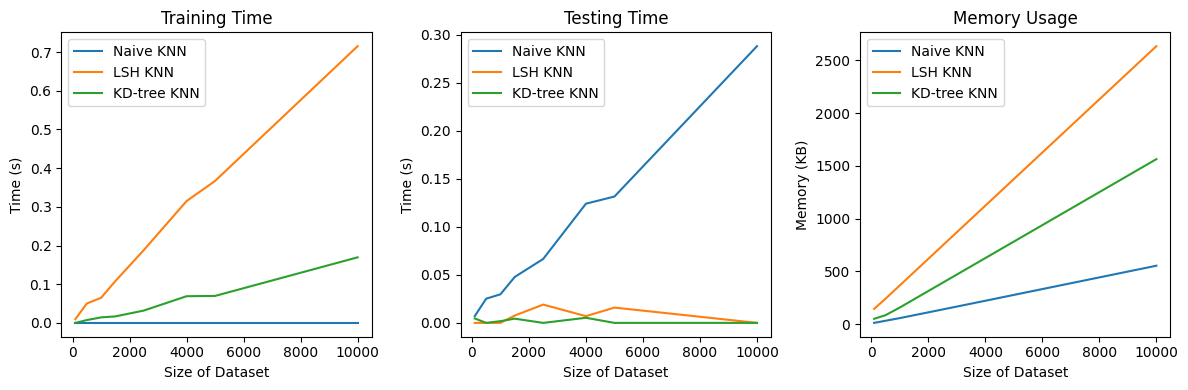

In [12]:
dataset_sizes=[100,500,1000,1500,2500,4000,5000,10000]
train_time_naive=[];train_time_lsh=[];train_time_kdt=[]
test_time_naive=[];test_time_lsh=[];test_time_kdt=[]
memory_naive=[];memory_lsh=[];memory_kdt=[]
for size in dataset_sizes:
    train_time, test_time, memory=metrics(size,20,5,'naive')
    train_time_naive.append(train_time);test_time_naive.append(test_time);memory_naive.append(memory)
    train_time, test_time, memory=metrics(size,20,5,'kdtree')
    train_time_kdt.append(train_time);test_time_kdt.append(test_time);memory_kdt.append(memory)
    train_time, test_time, memory=metrics(size,20,5,'lsh')
    train_time_lsh.append(train_time);test_time_lsh.append(test_time);memory_lsh.append(memory)

plot_metrics('Size of Dataset',dataset_sizes,train_time_naive,test_time_naive,memory_naive,train_time_kdt,test_time_kdt,memory_kdt,train_time_lsh,test_time_lsh,memory_lsh)

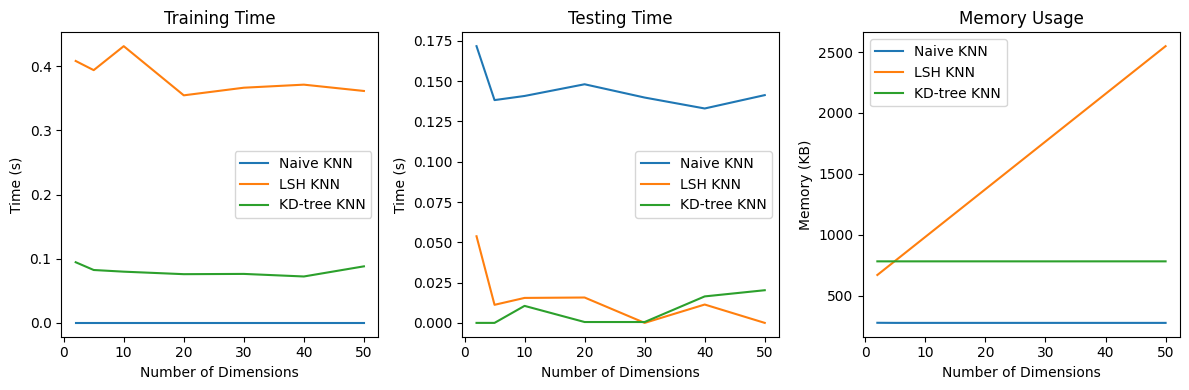

In [25]:
dimensions = [2, 5, 10, 20,30,40, 50]
train_time_naive=[];train_time_lsh=[];train_time_kdt=[]
test_time_naive=[];test_time_lsh=[];test_time_kdt=[]
memory_naive=[];memory_lsh=[];memory_kdt=[]
for size in dimensions:
    train_time, test_time, memory=metrics(5000,size,5,'naive')
    train_time_naive.append(train_time);test_time_naive.append(test_time);memory_naive.append(memory)
    train_time, test_time, memory=metrics(5000,size,5,'kdtree')
    train_time_kdt.append(train_time);test_time_kdt.append(test_time);memory_kdt.append(memory)
    train_time, test_time, memory=metrics(5000,size,5,'lsh')
    train_time_lsh.append(train_time);test_time_lsh.append(test_time);memory_lsh.append(memory)

plot_metrics('Number of Dimensions',dimensions,train_time_naive,test_time_naive,memory_naive,train_time_kdt,test_time_kdt,memory_kdt,train_time_lsh,test_time_lsh,memory_lsh)

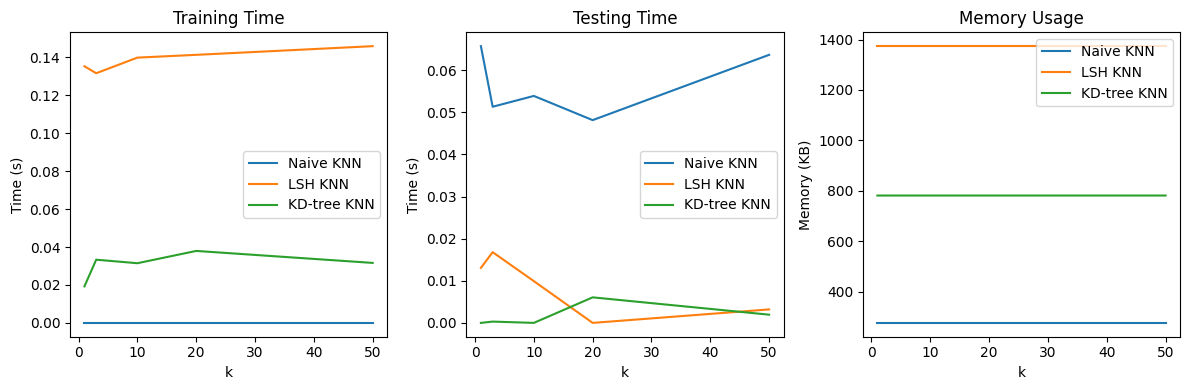

In [23]:
k = [1, 3, 10, 20, 50]
train_time_naive=[];train_time_lsh=[];train_time_kdt=[]
test_time_naive=[];test_time_lsh=[];test_time_kdt=[]
memory_naive=[];memory_lsh=[];memory_kdt=[]
for size in k:
    train_time, test_time, memory=metrics(5000,20,size,'naive')
    train_time_naive.append(train_time);test_time_naive.append(test_time);memory_naive.append(memory)
    train_time, test_time, memory=metrics(5000,20,size,'kdtree')
    train_time_kdt.append(train_time);test_time_kdt.append(test_time);memory_kdt.append(memory)
    train_time, test_time, memory=metrics(5000,20,size,'lsh')
    train_time_lsh.append(train_time);test_time_lsh.append(test_time);memory_lsh.append(memory)

plot_metrics('k',k,train_time_naive,test_time_naive,memory_naive,train_time_kdt,test_time_kdt,memory_kdt,train_time_lsh,test_time_lsh,memory_lsh)